<h2> Task1 - Import Libraries and Data set  </h2)

<h3>  1.1 Import Required Libraries </h3>

In [ ]:
#got images from https://www.kaggle.com/datasets/adityajn105/flickr8k?resource=download&select=Images
#got the captions from https://www.kaggle.com/datasets/adityajn105/flickr8k?resource=download&select=captions.txt
!pip install keras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from keras.applications.vgg16 import VGG16
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.models import Model
import os
import nltk
from nltk.translate.bleu_score import sentence_bleu

In [ ]:
import warnings
warnings.filterwarnings('ignore')

nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

<h3> 1.2 Check Availaility of GPU </h3>
<h4> Google Colab Pro which provides GPU/TPU & Higher RAM caapcity is used to run deep learning models. </h4>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


<h2> Task2 - Data Processing </h2>

<h3> 2.1 Read the Text File containing the Captions

In [ ]:
file1 = open('gdrive/My Drive/DL_Project/captions.txt', 'r')
new_dict = file1.readlines()
new_dict = [line[:-1] for line in new_dict]
new_dict = new_dict[1:]
new_dict[0:3]

['1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .',
 '1000268201_693b08cb0e.jpg,A girl going into a wooden building .',
 '1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .']

<h3> 2.2 Processing the Captions 

<h4> 2.2.1 Caption Processor </h4>

In [ ]:
# load the caption file & read it
def load_caption_file(path):
    
    # dictionary to store captions
    captions_dict = {}
    
    # iterate through the file
    for caption in path:
    
        # caption has format-> 2872963574_52ab5182cb.jpg#4,Two oppose hockey player collide .
        tokens = caption.split(',')
        caption_id, caption_text = tokens[0].split('.')[0], tokens[1]
        #caption_text = ' '.join(caption_text)
        
        # save it in the captions dictionary
        if caption_id not in captions_dict:
            captions_dict[caption_id] = [caption_text]
        else:
            captions_dict[caption_id].append(caption_text)
        
    return captions_dict

# call the function
captions_dict = load_caption_file(new_dict)

In [ ]:
len(captions_dict)

8091

In [ ]:
captions_dict[list(captions_dict.keys())[0]]

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

<h4> 2.2.2  Preprocess the captions </h4>



1) Convert the captions into lowercase

2) Tokenize the captions into different tokens

3) Remove all the punctuations from the tokens

4) add "startseq" and "endseq" as pointers to tell the model start of the caption and end of the caption

In [ ]:
# clean the captions
import string

# dictionary to store the cleaned captions
new_captions_dict = {}

# prepare translation table for removing punctuation. third argument is the list of punctuations we want to remove
table = str.maketrans('', '', string.punctuation)

# loop through the dictionary
for caption_id, caption_texts in captions_dict.items():
    #iterate through the 5 caption texts for each image
    for caption_text in caption_texts:
      # tokenize the caption_text
      caption_text = caption_text.split()
      # convert it into lower case
      caption_text = [token.lower() for token in caption_text]
      # remove punctuation from each token
      caption_text = [token.translate(table) for token in caption_text]
      # remove all the single letter tokens like 'a', 's'
      caption_text = [token for token in caption_text if len(token)>1]
      # store the cleaned captions
      if caption_id not in new_captions_dict:
        new_captions_dict[caption_id] = ['startseq ' + ' '.join(caption_text) + ' endseq']
      else:
        new_captions_dict[caption_id].append('startseq ' + ' '.join(caption_text) + ' endseq')
    

In [ ]:
# delete unwanted 
del captions_dict

In [ ]:
print('"' + list(new_captions_dict.keys())[1] + '"' + ' : ' + str(new_captions_dict[list(new_captions_dict.keys())[1]]))

"1001773457_577c3a7d70" : ['startseq black dog and spotted dog are fighting endseq', 'startseq black dog and tricolored dog playing with each other on the road endseq', 'startseq black dog and white dog with brown spots are staring at each other in the street endseq', 'startseq two dogs of different breeds looking at each other on the road endseq', 'startseq two dogs on pavement moving toward each other endseq']


In [ ]:
len(new_captions_dict)

8091

<h5> Make a list of only those images with captions </h5>

In [ ]:
import os

In [ ]:
caption_images_list = []

image_dataset_path = 'gdrive/My Drive/DL_Project/FlickrImages' # CHANGE THIS TO THE PATH WHERE IMAGES FOLDER IS DOWNLOADED

image_index = list(new_captions_dict.keys())

caption_images_list = [ image.split('.')[0] for image in os.listdir(image_dataset_path) if image.split('.')[0] in image_index ]

In [ ]:
caption_images_list[0]

'416788726_5b4eb1466e'

In [ ]:
len(caption_images_list)

8091

In [ ]:
#need to change this to appropriate number
8091-1010

7081

<h3> 2.3 Make training, validation and test data </h3>

<h4> Take 7081 images for training, 1000 for validation and rest 10 for testing </h4>

In [ ]:
train_validate_images = caption_images_list[0:8081]  

In [ ]:
test_images = caption_images_list[8081:8092]
test_images

['109823397_e35154645f',
 '1141718391_24164bf1b1',
 '1096165011_cc5eb16aa6',
 '1104133405_c04a00707f',
 '1107471216_4336c9b328',
 '111497985_38e9f88856',
 '1144288288_e5c9558b6a',
 '112178718_87270d9b4d',
 '1110208841_5bb6806afe',
 '1130401779_8c30182e3e']

<h3> 2.4  Plot Two samples and their captions </h3>

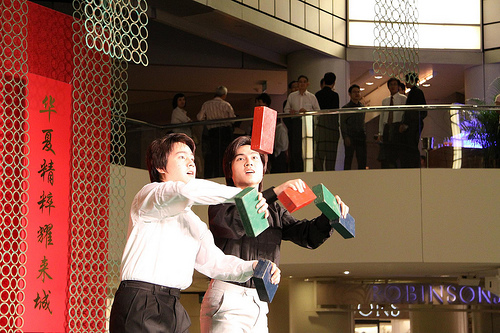

In [ ]:
from IPython.display import Image
Image(image_dataset_path+'/3165936115_cb4017d94e.jpg')

In [ ]:
new_captions_dict.get('3165936115_cb4017d94e')

['startseq two men juggling red endseq',
 'startseq two men look like they are playing with boxes in mall endseq',
 'startseq two men stand juggling colored boxes while other men stand on balcony endseq',
 'startseq two young asian men juggle colored boxes in mall endseq',
 'startseq two young men are juggling multicolored blocks with people watching endseq']

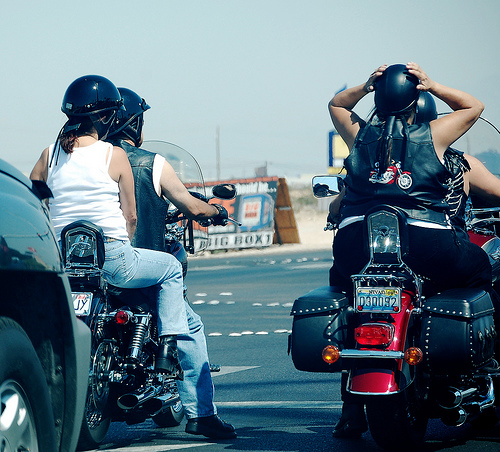

In [ ]:
Image(image_dataset_path+'/3083016677_5782bc337c.jpg')

In [ ]:
new_captions_dict.get('3083016677_5782bc337c')

['startseq motorcyclists near the beach endseq',
 'startseq there are two motorcycles with man and woman on it endseq',
 'startseq two guys with helmets are on motorcycles endseq',
 'startseq two motorcycles and four riders are on the road endseq',
 'startseq two motorcycles with two riders each endseq']

<h2> Task3 - Model Building </h2>

<h3> 3.1 Image Feature Extractor </h3> 
<h3> Use Pretrained VGG model trained on ImageNet dataset for image feature extraction.  </h3>

In [ ]:
# extract features from each photo in the directory
def extract_features(directory, image_keys):
    # load the model
    model = VGG16()
    
    # re-structure the model
    model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
    
    # summarize
    print(model.summary())
    
    # extract features from each photo
    features = dict()
    
    for name in image_keys:
        
        # load an image from file
        filename = directory + '/' + name + '.jpg'
        
        # load the image and convert it into target size of 224*224
        image = load_img(filename, target_size=(224, 224))
        
        # convert the image pixels to a numpy array
        image = img_to_array(image)
        
        # reshape data for the model
        image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
        
        # prepare the image for the VGG model
        image = preprocess_input(image)
        
        # get features
        feature = model.predict(image, verbose=0)
        
        # get image id
        image_id = name.split('.')[0]
        
        # store feature
        features[image_id] = feature
        
#         print('>%s' % name)
        

    return features

<h3> Extracting Image Features </h3>

In [ ]:
# extracting image features for train_validate_images
train_validate_features = extract_features(image_dataset_path, train_validate_images)

553467096/553467096 [==============================] - 2s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

In [ ]:
print("{} : {}".format(list(train_validate_features.keys())[0], train_validate_features[list(train_validate_features.keys())[0]] ))

416788726_5b4eb1466e : [[0.        0.        0.        ... 0.        0.7954495 0.       ]]


In [ ]:
len(train_validate_features)

8081

In [ ]:
from pickle import dump
dump(train_validate_features, open('./train_validate_features.pkl', 'wb'))

In [ ]:
from pickle import load
with open('gdrive/My Drive/DL_Project/train_validate_features_VGG_GRU.pkl', 'rb') as handle:
    train_validate_features = load(handle)

<h3>  3.2 Preparing the input data </h3>

Each caption will be split into words. The model will be provided one word and the image and generate the next word. Then the first two words of the description will be provided to the model as input with the image to generate the next word. This is how the model will be trained. So we will have two features, x1 (image) , x2 (text_sequence) and one target variable, y (generated_word).

Image,		   text sequence, 						generated_word

photo	         startseq, 									little

photo	       startseq, little,							girl

photo	       startseq, little, girl, 					running

photo	       startseq, little, girl, running, 			in

photo	       startseq, little, girl, running, in, 		field

photo	       startseq, little, girl, running, in, field, endseq

<h4> 3.2.1 Load Required Libraies </h4>

In [ ]:
# load libraries
import numpy as np
from keras.models import Model, load_model
from keras.layers import Input, Dense, Dropout, GRU, Embedding
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras import regularizers
from tensorflow.keras.layers import add
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [ ]:
max_len = max(len(caption.split()) for image in new_captions_dict for caption in new_captions_dict[image])
max_len

31

In [ ]:
# make a dictionary of image with caption for train_validate_images
train_validate_image_caption = {}

for image, captions in new_captions_dict.items():
    
    # check whether the image is available in both train_validate_images list and train_validate_features dictionary
    if image in train_validate_images and image in list(train_validate_features.keys()):
        
        for caption in captions:
            if image not in train_validate_image_caption:
                train_validate_image_caption[image] = [caption]
            else:
                train_validate_image_caption[image].append(caption)

len(train_validate_image_caption)

8081

<h4> 3.2.2 make sure the correct caption is mapped with the correct image </h4>

In [ ]:
list(train_validate_image_caption.values())[1]

['startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tricolored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

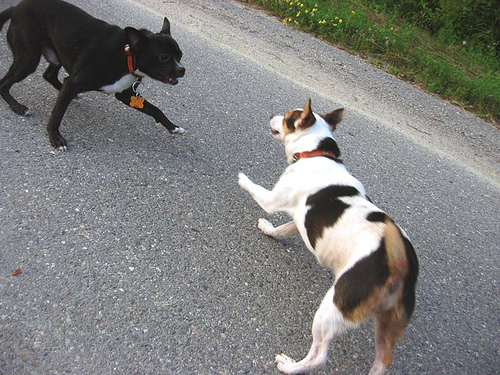

In [ ]:
Image(image_dataset_path+'/'+list(train_validate_image_caption.keys())[1]+'.jpg')

In [ ]:
# initialise tokenizer
tokenizer = Tokenizer()

# create word count dictionary on the captions list
tokenizer.fit_on_texts(list(np.concatenate(list(train_validate_image_caption.values()))))

# how many words are there in the vocabulary? store the total length in vocab_len and add 1 because word_index starts with 1 not 0 
vocab_len = len(tokenizer.word_index) + 1

# store the length of the maximum sentence
max_len = max(len(caption.split()) for image in train_validate_image_caption for caption in train_validate_image_caption[image])

def prepare_data(image_keys):
    
    # x1 will store the image feature, x2 will store one sequence and y will store the next sequence
    x1, x2, y = [], [], []

    # iterate through all the images 
    for image in image_keys:

        # store the caption of that image
        captions = train_validate_image_caption[image]
        
        for caption in captions:


          # split the image into tokens
          caption = caption.split()

          # generate integer sequences of the 
          seq = tokenizer.texts_to_sequences([caption])[0]

          length = len(seq)

          for i in range(1, length):

              x2_seq, y_seq = seq[:i] , seq[i]  

              # pad the sequences
              x2_seq = pad_sequences([x2_seq], maxlen = max_len)[0]


              # encode the output sequence                
              y_seq = to_categorical([y_seq], num_classes = vocab_len)[0]

              x1.append( train_validate_features[image][0] )
  
              x2.append(x2_seq)
  
              y.append(y_seq)
                 
    return np.array(x1), np.array(x2), np.array(y)

In [ ]:
train_x1, train_x2, train_y = prepare_data( train_validate_images[0:7081] )
validate_x1, validate_x2, validate_y = prepare_data( train_validate_images[7081:8081] )

In [ ]:
shuffler = np.random.RandomState(seed=40).permutation(len(train_x1))
train_x1 = train_x1[shuffler]
train_x2 = train_x2[shuffler]
train_y = train_y[shuffler]

In [ ]:
len(train_x1)

347037

In [ ]:
len(validate_x1)

49954

<h3> Task4 - Create 3-layered GRU layer model and other relevant layers for image caption generation and Compile the Model</h3>

<h4> 4.1 Add Regularization, Dropout and Choose Appropriate Activation Function & Loss Function and Print Model Summary </h4>

In [ ]:
# feature extractor model
input_1 = Input(shape=(4096,))
droplayer = Dropout(0.5)(input_1)
denselayer = Dense(256, activation='relu')(droplayer)

# sequence model
input_2 = Input(shape=(max_len,))
embedding = Embedding(vocab_len, 256, mask_zero=True)(input_2)
droplayer_ = Dropout(0.5)(embedding)
gru = GRU(256)(droplayer_)

# decoder model
decoder1 = add([denselayer, gru])
decoder2 = Dense(256, activation='relu',kernel_regularizer=regularizers.l2(0.005),activity_regularizer=regularizers.l2(0.005))(decoder1)
outputs = Dense(vocab_len, activation='softmax')(decoder2)

# tie it together [image, seq] [word]
model = Model(inputs=[input_1, input_2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# summarize model
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 31)]         0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None, 4096)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 31, 256)      2203136     ['input_2[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 4096)         0           ['input_1[0][0]']                
                                                                                              

<h4> 4.2 Plot the model architecture </h4>

```
# This is formatted as code
```



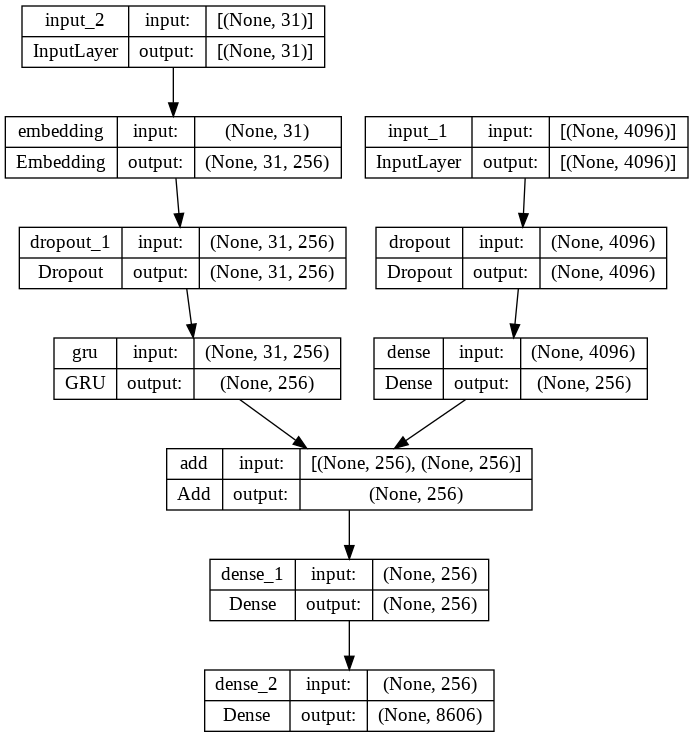

In [ ]:
plot_model(model, to_file='model.png', show_shapes=True)

<h4> 4.3 Make sure feature data and target data share the same first dimension </h4>

In [ ]:
print("shape of train_x1 ", train_x1.shape)
print("shape of train_x2 ", train_x2.shape)
print("shape of train_y ", train_y.shape)
print()
print("shape of validate_x1 ", validate_x1.shape)
print("shape of validate_x2 ", validate_x2.shape)
print("shape of validate_y ", validate_y.shape)

shape of train_x1  (347037, 4096)
shape of train_x2  (347037, 31)
shape of train_y  (347037, 8606)

shape of validate_x1  (49954, 4096)
shape of validate_x2  (49954, 31)
shape of validate_y  (49954, 8606)


<h4> 4.4 Initialize a model checkpoint object to capture the model instance giving the least validation loss </h4>

In [ ]:
model_checkpoint = ModelCheckpoint('model_VGG_GRU.h5', 
                                   save_best_only = True,
                                   monitor = 'val_loss',
                                   verbose = 1)

<h2> Task5 - Train the model using training data and validation data </h2>

<h3> 5.1 Train the model for an appropriate number of epochs. Print the train and validation loss for each epoch. Use the appropriate batch size.  </h3> 

In [ ]:
# fit model
history = model.fit([train_x1, train_x2],  
                    train_y,              
                    verbose = 1,
                    batch_size = 512,            
                    epochs = 15,            
                    validation_data=([validate_x1, validate_x2], validate_y),
                    callbacks = [model_checkpoint]) 

Epoch 1/15
678/678 [==============================] - ETA: 0s - loss: 5.1873
Epoch 1: val_loss improved from inf to 4.34299, saving model to model_VGG_GRU.h5
678/678 [==============================] - 147s 211ms/step - loss: 5.1873 - val_loss: 4.3430
Epoch 2/15
678/678 [==============================] - ETA: 0s - loss: 4.0657
Epoch 2: val_loss improved from 4.34299 to 4.06826, saving model to model_VGG_GRU.h5
678/678 [==============================] - 143s 210ms/step - loss: 4.0657 - val_loss: 4.0683
Epoch 3/15
678/678 [==============================] - ETA: 0s - loss: 3.7958
Epoch 3: val_loss improved from 4.06826 to 3.93291, saving model to model_VGG_GRU.h5
678/678 [==============================] - 143s 211ms/step - loss: 3.7958 - val_loss: 3.9329
Epoch 4/15
678/678 [==============================] - ETA: 0s - loss: 3.6329
Epoch 4: val_loss improved from 3.93291 to 3.85040, saving model to model_VGG_GRU.h5
678/678 [==============================] - 145s 214ms/step - loss: 3.6329 - v

<h3> 5.2 Plot the loss and accuracy history graphs for both train and validation set. Print the total time taken for training. </h3>

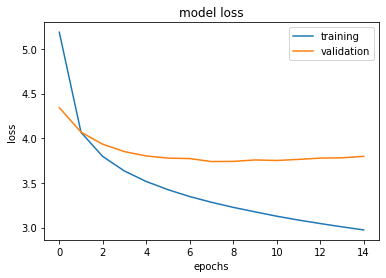

In [ ]:
# plot training loss and validation loss
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

<h2> Task6 - Model Evaluation </h2>

In [ ]:
# extract features from each photo in the directory
def extract_feat(filename):
    # load the model
    model = VGG16()
    # re-structure the model
    model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
    # load the photo
    image = load_img(filename, target_size=(224, 224))
    # convert the image pixels to a numpy array
    image = img_to_array(image)
    # reshape data for the model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # prepare the image for the VGG model
    image = preprocess_input(image)
    # get features
    feature = model.predict(image, verbose=0)
    return feature

# map an integer to a word
def word_for_id(integer, tokenizr):
    for word, index in tokenizr.word_index.items():
        if index == integer:
            return word
    return None
 

In [ ]:
# generate a description for an image
def generate_desc(model, tokenizer, photo, max_length):
    # seed the generation process
    in_text = 'startseq'
    # iterate over the whole length of the sequence
    for i in range(max_length):
        # integer encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad input
        sequence = pad_sequences([sequence], maxlen=max_length)
        # predict next word
        yhat = model.predict([photo,sequence], verbose=0)
        # convert probability to integer
        yhat = np.argmax(yhat)
        # map integer to word
        word = word_for_id(yhat, tokenizer)
        # stop if we cannot map the word
        if word is None:
            break
        # append as input for generating the next word
        in_text += ' ' + word
        # stop if we predict the end of the sequence
        if word == 'endseq':
            break
    return in_text

<h3> 6.1 Evaluating model on training images using the latest model </h3>

553467096/553467096 [==============================] - 3s 0us/step


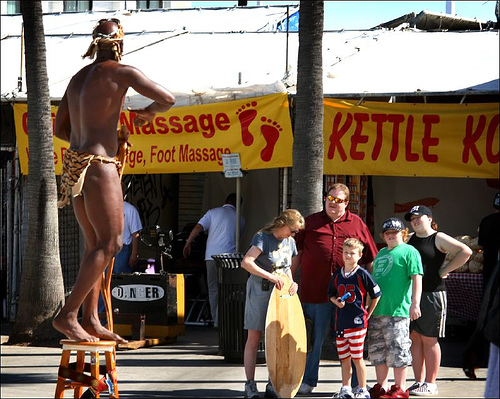

Predicted caption ->  startseq man in red shirt and black pants is standing in front of building endseq

Actual captions ->
startseq family of five is watching performer standing on stepstool endseq
startseq group of people watch man standing on stool dressed in thong endseq
startseq halfnaked performer is performing for small crowd outside endseq
startseq man in small bathing suit standing on stool at tourist location endseq
startseq mostly nude man standing on stool while family of look at him questioningly endseq

BLEU-1 score -> 0.4666666666666667
BLEU-2 score -> 0.25819888974716115
BLEU-3 score -> 0.17550463005823083
BLEU-4 score -> 3.2683416997819595e-78
*********************************************************************


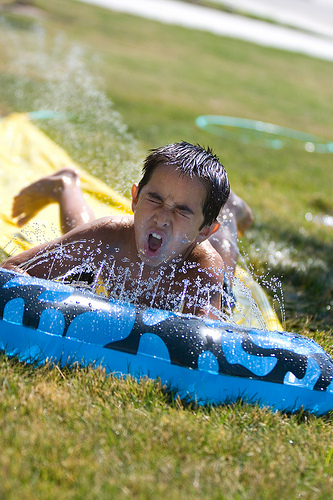

Predicted caption ->  startseq boy in blue shirt is jumping into pool endseq

Actual captions ->
startseq boy at the end of slip and slide endseq
startseq boy is being splashed in the face whilst riding blue ring along yellow water slide endseq
startseq young boy slides down water slide with his eyes closed endseq
startseq young boy slides on slip slide endseq
startseq young boy splashes down water slide on lawn endseq

BLEU-1 score -> 0.6
BLEU-2 score -> 0.25819888974716104
BLEU-3 score -> 1.2204318888845425e-102
BLEU-4 score -> 7.57965434483665e-155
*********************************************************************


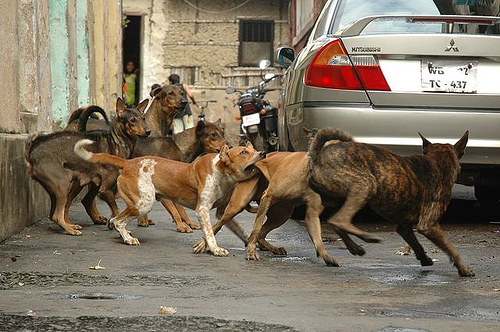

Predicted caption ->  startseq two dogs are playing in the snow endseq

Actual captions ->
startseq group of dogs standing by car endseq
startseq pack of dogs fighting near car in an alley endseq
startseq pack of dogs roughhousing by car on dirty street endseq
startseq several dogs brawl in an alley near silver car endseq
startseq three dogs look on as two dogs attack third dog in the streets endseq

BLEU-1 score -> 0.6666666666666666
BLEU-2 score -> 0.408248290463863
BLEU-3 score -> 1.6513295394012967e-102
BLEU-4 score -> 9.53091075863908e-155
*********************************************************************


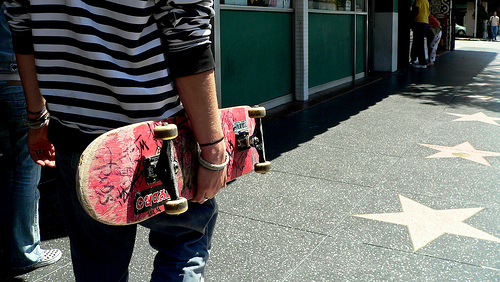

Predicted caption ->  startseq man in black shirt and black hat is standing in front of brick building endseq

Actual captions ->
startseq boy in black and white shirt holds red skateboard as he stands over the hollywood stars endseq
startseq skateboarder examines the hollywood walk of fame endseq
startseq teenage boy wearing striped shirt walks on street paved with stars carrying skateboard endseq
startseq man walking with red skateboard endseq
startseq person wearing black and white striped shirt holding red skateboard standing on sidewalk with stars endseq

BLEU-1 score -> 0.5625
BLEU-2 score -> 0.27386127875258304
BLEU-3 score -> 1.2688020722692023e-102
BLEU-4 score -> 7.806161490833773e-155
*********************************************************************


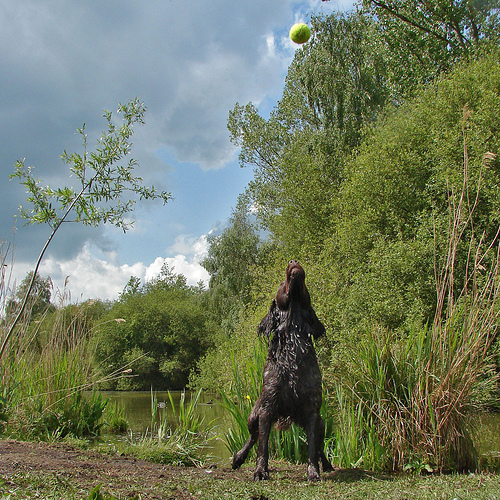

Predicted caption ->  startseq dog is running through the snow endseq

Actual captions ->
startseq black dog looks up at ball in the air and prepares to catch it endseq
startseq black dog waits on the grass for falling yellow ball endseq
startseq dog is looking up at ball attached to the string endseq
startseq the animal is near the pond endseq
startseq the dinosaur exhibt is next to tree that has balloon stuck in its branches endseq

BLEU-1 score -> 0.625
BLEU-2 score -> 0.42257712736425823
BLEU-3 score -> 0.3135508904498039
BLEU-4 score -> 5.072841446586652e-78
*********************************************************************


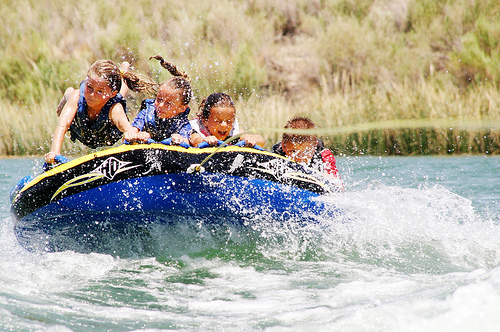

Predicted caption ->  startseq man in red shirt is riding wave on the beach endseq

Actual captions ->
startseq four children lay on tube endseq
startseq several girls on raft floating in rough waters endseq
startseq the four kids are riding raft on the water endseq
startseq the kids ride boat in the water endseq
startseq three girls and one boy are holding onto raft as they are being pulled by road through the water endseq

BLEU-1 score -> 0.5
BLEU-2 score -> 0.21320071635561041
BLEU-3 score -> 1.0755340835777305e-102
BLEU-4 score -> 6.887578243315168e-155
*********************************************************************


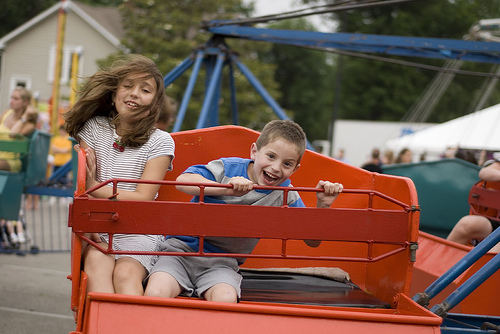

Predicted caption ->  startseq girl in pink shirt is sitting on bench endseq

Actual captions ->
startseq boy and girl are riding in red seat on fairground ride endseq
startseq girl and boy enjoy fast amusement ride endseq
startseq young girl and boy on ride at an amusement park endseq
startseq two children ride in red seat on fair ride and smile endseq
startseq two kids are on fair ride and are slipping to one side of the car endseq

BLEU-1 score -> 0.5
BLEU-2 score -> 0.2357022603955158
BLEU-3 score -> 1.149168560061151e-102
BLEU-4 score -> 7.241926111174567e-155
*********************************************************************


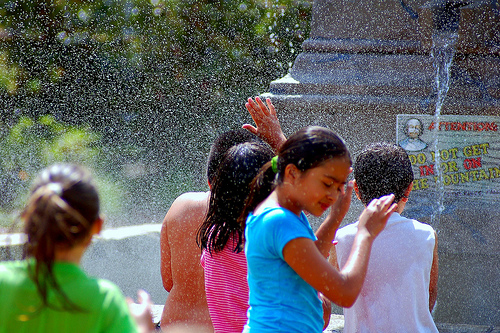

Predicted caption ->  startseq boy in blue shirt is jumping into pool endseq

Actual captions ->
startseq group of kids plays in the spray of water from fountain endseq
startseq children are being splashed with water endseq
startseq children are playing outside in fountain endseq
startseq five children are being sprayed by water fountain endseq
startseq four children are playing in water fountain endseq

BLEU-1 score -> 0.3
BLEU-2 score -> 8.170202920075766e-155
BLEU-3 score -> 5.979947053917884e-204
BLEU-4 score -> 1.3483065280626046e-231
*********************************************************************


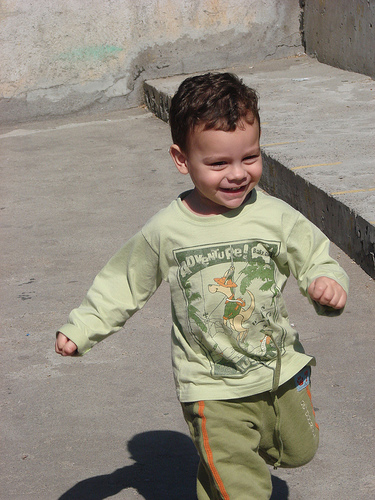

Predicted caption ->  startseq man in red shirt and black pants is standing in front of building endseq

Actual captions ->
startseq boy runs near some steps endseq
startseq little boy is running on some concrete steps endseq
startseq young boy in green shirt and green sweat pants running on concrete floor endseq
startseq young boy runs down cement stairway endseq
startseq the small boy is running and smiling endseq

BLEU-1 score -> 0.4666666666666667
BLEU-2 score -> 0.18257418583505536
BLEU-3 score -> 9.708980935455592e-103
BLEU-4 score -> 6.373704167435469e-155
*********************************************************************


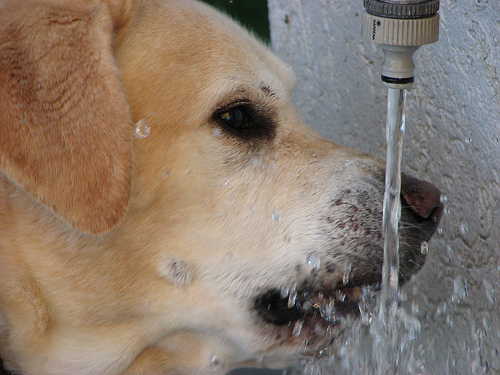

Predicted caption ->  startseq dog is running through the water endseq

Actual captions ->
startseq brown dog drinks from water bottle endseq
startseq tan dog has drink from water being poured from spout endseq
startseq yellow lab drinks water endseq
startseq the yellow dog is drinking water from bottle endseq
startseq yellow labrador drinking water from faucet endseq

BLEU-1 score -> 0.75
BLEU-2 score -> 0.46291004988627577
BLEU-3 score -> 1.794119740213648e-102
BLEU-4 score -> 1.0148936155293581e-154
*********************************************************************


In [ ]:
from keras.models import load_model
# load the model
modl = load_model('model_VGG_GRU.h5')

# generate description
tokenizr = Tokenizer()
tokenizr.fit_on_texts([caption for image in train_validate_images for caption in new_captions_dict[image]])
max_length = 31

for count in range(10):

    photo = extract_feat('{}.jpg'.format(image_dataset_path+'/'+train_validate_images[count*100])) 

    # reference captions list of the training image for BLEU Score calculation
    ref_bleu = []
    for caption in new_captions_dict[train_validate_images[count*100]]:
       ref_bleu.append(caption.split())

    # generate description
    description = generate_desc(modl, tokenizr, photo, max_length)
    display(Image(image_dataset_path+'/'+train_validate_images[count*100]+'.jpg'))
    print('Predicted caption -> ', description)
    print()
    print('Actual captions ->')
    for caption in new_captions_dict[train_validate_images[count*100]]: print(caption)
    print()
    print('BLEU-1 score -> {}'.format(sentence_bleu(ref_bleu, description.split(), weights=(1.0, 0, 0, 0))))
    print('BLEU-2 score -> {}'.format(sentence_bleu(ref_bleu, description.split(), weights=(0.5, 0.5, 0, 0))))
    print('BLEU-3 score -> {}'.format(sentence_bleu(ref_bleu, description.split(), weights=(0.33, 0.33, 0.33, 0))))
    print('BLEU-4 score -> {}'.format(sentence_bleu(ref_bleu, description.split(), weights=(0.25, 0.25, 0.25, 0.25))))
    print('*********************************************************************')

<h3> 6.2 Evaluating model on test images </h3>

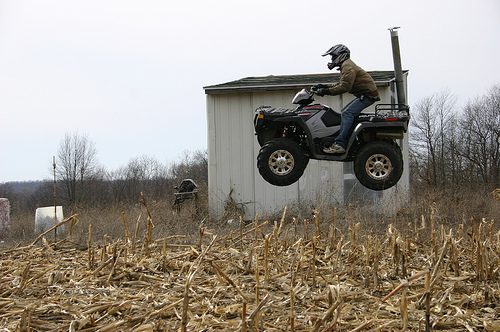

Predicted caption ->  startseq boy in dogs while man it and the camera endseq

Actual caption ->
startseq man jumps gin the air while riding an atv endseq
startseq man on fourwheeler jumps near small building endseq
startseq an atv is airborne over field in front of white structure endseq
startseq person dressed in tan jacket jumps quad over harvested cornfield in front of small out building endseq
startseq man on four wheeler in the air endseq

BLEU-1 score -> 0.5454545454545454
BLEU-2 score -> 1.1016699370024176e-154
BLEU-3 score -> 7.284129382816144e-204
BLEU-4 score -> 1.5656618337072542e-231
*********************************************************************


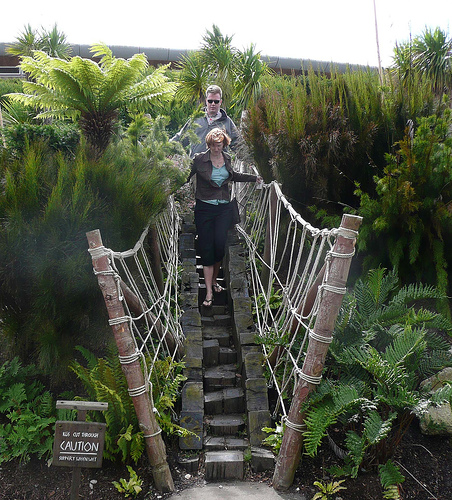

Predicted caption ->  startseq boy in dogs while man blue holds sand the climbing endseq

Actual caption ->
startseq bridge through high green plants endseq
startseq man and woman are crossing over rope bridge with greenery all over them endseq
startseq man and woman are walking across rope bridge endseq
startseq man and woman crossing suspension bridge in tropical setting endseq
startseq woman and man walking across wooden rope bridge with caution sign beside it endseq

BLEU-1 score -> 0.3333333333333333
BLEU-2 score -> 8.612150057732663e-155
BLEU-3 score -> 6.19152043543562e-204
BLEU-4 score -> 1.384292958842266e-231
*********************************************************************


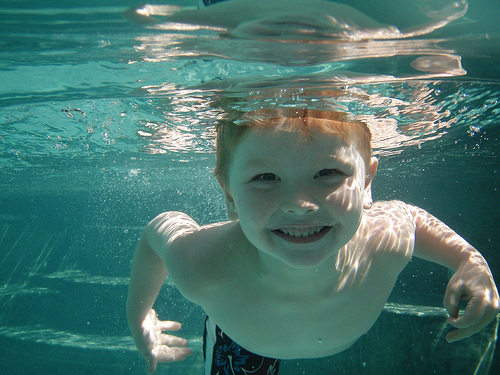

Predicted caption ->  startseq brown in person

Actual caption ->
startseq boy smiles underwater endseq
startseq redheaded boy swimming underwater endseq
startseq small boy swimming underwater endseq
startseq smiling boy swims underwater in pool endseq
startseq the boys smiles underwater at the pool endseq

BLEU-1 score -> 0.38940039153570244
BLEU-2 score -> 8.214546595247418e-155
BLEU-3 score -> 5.512312187546572e-204
BLEU-4 score -> 1.1931009847695213e-231
*********************************************************************


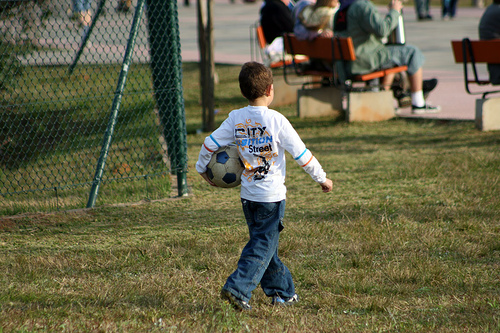

Predicted caption ->  startseq white across girl setting endseq

Actual caption ->
startseq boy carrying soccer ball endseq
startseq boy walks with ball tucked under his arm endseq
startseq boy walks with soccer ball near fence endseq
startseq boy wearing white tshirt walks on the grass and carries soccer ball endseq
startseq small boy carries soccer ball on field endseq

BLEU-1 score -> 0.5
BLEU-2 score -> 1.0547686614863434e-154
BLEU-3 score -> 7.077948953527403e-204
BLEU-4 score -> 1.5319719891192393e-231
*********************************************************************


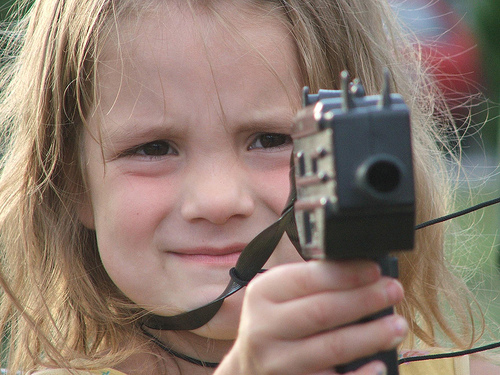

Predicted caption ->  startseq through in person while man snowboard in person

Actual caption ->
startseq little girl is holding cine camera in front of her face endseq
startseq young girl is looking through an old fashioned video camera endseq
startseq young girl steadies her aim with camera endseq
startseq girl with rosy cheeks and lips holding black toy gun endseq
startseq there is kid with gun endseq

BLEU-1 score -> 0.3333333333333333
BLEU-2 score -> 8.612150057732663e-155
BLEU-3 score -> 6.19152043543562e-204
BLEU-4 score -> 1.384292958842266e-231
*********************************************************************


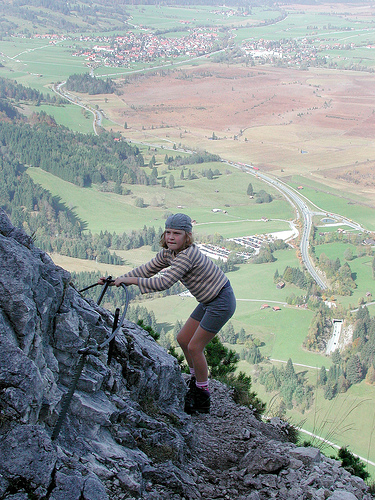

Predicted caption ->  startseq boy in dogs while on an

Actual caption ->
startseq kid rock climbing against the backdrop of green valley endseq
startseq woman in striped shirt climbs up mountain endseq
startseq young man climbs rocky hill endseq
startseq the person has striped shirt on and is holding on to rope on mountain endseq
startseq the person in the striped shirt is mountain climbing endseq

BLEU-1 score -> 0.42857142857142855
BLEU-2 score -> 9.765260274142007e-155
BLEU-3 score -> 6.726900215918542e-204
BLEU-4 score -> 1.4740564900137075e-231
*********************************************************************


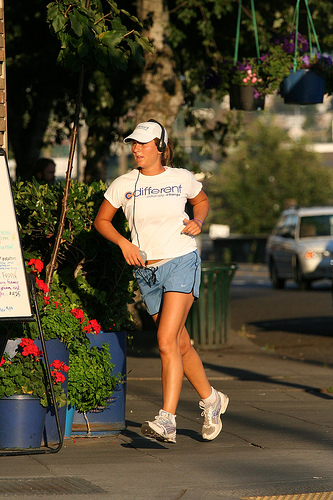

Predicted caption ->  startseq boy in person while on an

Actual caption ->
startseq man in shorts is jogging along street with headset endseq
startseq person in blue shorts and wearing walkman jogs endseq
startseq woman in white shirt and blue shorts is wearing headphones endseq
startseq woman walks on street wearing headphones endseq
startseq woman wearing white hat and shirt is jogging down street with plant store on the corner endseq

BLEU-1 score -> 0.4953587998572467
BLEU-2 score -> 9.77487297713204e-155
BLEU-3 score -> 6.412135627211214e-204
BLEU-4 score -> 1.3731144660140744e-231
*********************************************************************


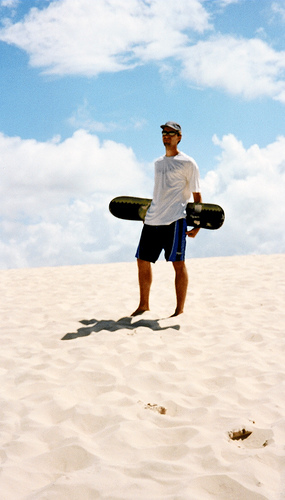

Predicted caption ->  startseq boy in dogs while on an creating man are in the rosy endseq

Actual caption ->
startseq guy stands in the sand with snowboard behind him endseq
startseq man holds surfboard on the beach endseq
startseq man holds his snowboard in the sand endseq
startseq man with his surfboard stands in the sand endseq
startseq man is standing on white sand and holding snowboard endseq

BLEU-1 score -> 0.42857142857142855
BLEU-2 score -> 0.1815682598006407
BLEU-3 score -> 9.673642131003819e-103
BLEU-4 score -> 6.356121367760845e-155
*********************************************************************


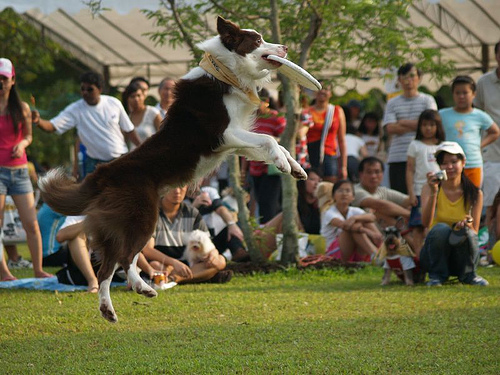

Predicted caption ->  startseq white rope front girl is setting his in the camera endseq

Actual caption ->
startseq black and white border collie catches frisbee in front of an audience endseq
startseq brown and white dog catches frisbee in it mouth in front of group of people endseq
startseq brown and white dug jumping up to catch frisbee while an audience watches endseq
startseq dog jumps to catch frisbee endseq
startseq an agile dog catches frisbee while crowd of onlookers watches closely endseq

BLEU-1 score -> 0.38335183942888473
BLEU-2 score -> 8.858810016395679e-155
BLEU-3 score -> 6.131777791514501e-204
BLEU-4 score -> 1.3466796774819026e-231
*********************************************************************


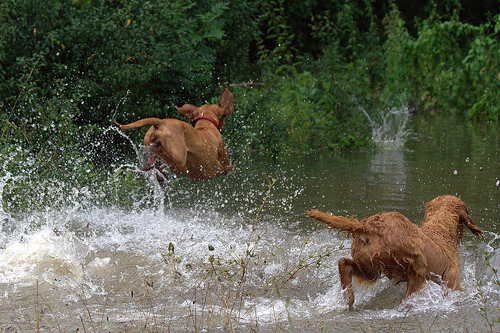

Predicted caption ->  startseq with man soccer walks the frisbee endseq

Actual caption ->
startseq two brown dogs are creating large splashes as they run in river endseq
startseq two brown dogs in the water endseq
startseq two brown dogs running through water endseq
startseq two brown dogs runs through the water endseq
startseq two dogs splash through the water endseq

BLEU-1 score -> 0.375
BLEU-2 score -> 9.134564559628536e-155
BLEU-3 score -> 6.43691305555604e-204
BLEU-4 score -> 1.4256605770826504e-231
*********************************************************************


In [ ]:
# load the model
modl = load_model('model_VGG_GRU.h5')

# generate description
tokenizr = Tokenizer()
tokenizr.fit_on_texts([caption for image in test_images for caption in new_captions_dict[image]])
max_length = 31

for count in range(10):

    photo = extract_feat('{}.jpg'.format(image_dataset_path+'/'+test_images[count]))

    # reference captions list of the testing image for BLEU Score calculation
    ref_bleu = []
    for caption in new_captions_dict[test_images[count]]:
      ref_bleu.append(caption.split())

    # generate description
    description = generate_desc(modl, tokenizr, photo, max_length)
    display(Image('{}.jpg'.format(image_dataset_path+'/'+test_images[count])))
    print('Predicted caption -> ', description)
    print()
    print('Actual caption ->')
    for caption in new_captions_dict[test_images[count]]: print(caption)
    print()
    print('BLEU-1 score -> {}'.format(sentence_bleu(ref_bleu, description.split(), weights=(1.0, 0, 0, 0))))
    print('BLEU-2 score -> {}'.format(sentence_bleu(ref_bleu, description.split(), weights=(0.5, 0.5, 0, 0))))
    print('BLEU-3 score -> {}'.format(sentence_bleu(ref_bleu, description.split(), weights=(0.33, 0.33, 0.33, 0))))
    print('BLEU-4 score -> {}'.format(sentence_bleu(ref_bleu, description.split(), weights=(0.25, 0.25, 0.25, 0.25))))
    print('*********************************************************************')